# House Prices Prediction - Part 3
## Testing feature selection with diffent ML models

# Selection process (num + cat)

In parts 1 and 2, we defined both numerical and categorical features selection. Each part provides the selected features as a CSV file. If more than one optionwas available, then more than one file is provided. We will merge all features into one dataframe and then run several tests to evaluate different models performance.

In [77]:
# %load project_dependencies.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import re
from itertools import product

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_log_error
from sklearn import linear_model
from sklearn.model_selection import KFold

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Example with one set of the available file sets

In [78]:
df_num = pd.read_csv("out/house_prices_num_feats_train.csv", index_col='Id')
df_cat = pd.read_csv("out/house_prices_cat_feats_na_3_nom_T_ord_T_Count_train.csv", index_col='Id')

In [79]:
df_num.head()

OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  TotalBsmtSF  \
Id                                                                              
1      0.666667   0.949275      0.883333     0.12250    0.125089     0.140098   
2      0.555556   0.753623      0.433333     0.00000    0.173281     0.206547   
3      0.666667   0.934783      0.866667     0.10125    0.086109     0.150573   
4      0.666667   0.311594      0.333333     0.00000    0.038271     0.123732   
5      0.777778   0.927536      0.833333     0.21875    0.116052     0.187398   

    1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  Fireplaces  GarageCars  \
Id                                                                        
1   0.119780   0.259231  0.666667      0.500000    0.000000        0.50   
2   0.212942   0.174830  0.666667      0.333333    0.333333        0.50   
3   0.134465   0.273549  0.666667      0.333333    0.333333        0.50   
4   0.143873   0.260550  0.333333      0.416667    0.333333        0.75   
5   0.186095   0.351168  0.666667      0.583333    0.333333        0.75   

    GarageArea  SalePrice  
Id                         
1     0.386460     208500  
2     0.324401     181500  
3     0.428773     223500  
4     0.452750     140000  
5     0.589563     250000

In [80]:
# Categorical features should be scaled as we did with numericals
df_cat.head()

nom_PConc  Functional_CE  nom_RH  GarageCond_CE  nom_Grvl  nom_RRNn  \
Id                                                                        
1    0.999001       0.999999     0.0       0.999999       0.0       0.0   
2    0.000000       0.999999     0.0       0.999999       0.0       0.0   
3    0.999001       0.999999     0.0       0.999999       0.0       0.0   
4    0.000000       0.999999     0.0       0.999999       0.0       0.0   
5    0.999001       0.999999     0.0       0.999999       0.0       0.0   

    nom_1Story  nom_Basment  nom_Slab  HeatingQC_CE  ...  nom_FR3  nom_1Fam  \
Id                                                   ...                      
1     0.000000          0.0       0.0      0.999999  ...      0.0  0.999001   
2     0.999001          0.0       0.0      0.999999  ...      0.0  0.999001   
3     0.000000          0.0       0.0      0.999999  ...      0.0  0.999001   
4     0.000000          0.0       0.0      0.324324  ...      0.0  0.999001   
5     0.000000          0.0       0.0      0.999999  ...      0.0  0.999001   

    nom_1.5Fin  nom_SFoyer  nom_RRAn  nom_Alloca  nom_Wall  nom_Pave  \
Id                                                                     
1          0.0         0.0       0.0         0.0       0.0  0.999001   
2          0.0         0.0       0.0         0.0       0.0  0.999001   
3          0.0         0.0       0.0         0.0       0.0  0.999001   
4          0.0         0.0       0.0         0.0       0.0  0.999001   
5          0.0         0.0       0.0         0.0       0.0  0.999001   

    nom_2Story  nom_Family  
Id                          
1     0.999001         0.0  
2     0.000000         0.0  
3     0.999001         0.0  
4     0.999001         0.0  
5     0.999001         0.0  

[5 rows x 97 columns]

In [81]:
# Check shape form when joining
df = df_num.join(df_cat, how='inner')
print("Shapes: {} + {} = {}".format(df_num.shape, df_cat.shape, df.shape))

Shapes: (1460, 14) + (1460, 97) = (1460, 111)


In [82]:
def peek_features(df_num, target='SalePrice', use_numerical=True, use_categorical=False):
    """
    Help function to select numerical / categorical features for analysis
    """
    
    if use_numerical or use_categorical:
        if use_numerical:
            df_out = pd.concat([df_out, df_num], axis=1)
        else:
            # Keep the target column alive
            df_out = df_in[target].copy()
            useful_feats = list(target)

        if use_categorical:
            df_cat, useful_feats_cat = select_cat_features(df_in)
            df_out = pd.concat([df_out, df_cat], axis=1, join='inner')

    else:
        print("No numerical nor categorical features are selected, returning empty Dataframe")

    useful_feats.extend(useful_feats_cat)
    
    return df_out, useful_feats

## Evaluating the features with a linear regression technique

As error metric evaluation, I will use [Root Mean Squared Log Error](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a) (RMSLE).

In [83]:
def evaluate_features(df, target="SalePrice"):  
    """
    Split the train dataset in train and test sets
    """
    train = df[:1100]
    test = df[1100:]
    
    features = train.drop(target, axis=1).columns
    # Model fit and predictions
    lr = linear_model.LinearRegression()
    lr.fit(train[features], train[target])
    predictions = lr.predict(test[features])
    
    # Error evaluation
        # A LR model makes negative predictions sometimes.
        # We use abs() to solve it as temporary solution
    msle = mean_squared_log_error(test[target], [abs(x) for x in predictions])
    rmsle = np.sqrt(msle)
    
    return rmsle

In [84]:
evaluate_features(df)

2.8914195429582987

The RMSLE value is way too high but this is somehow as espected. We did just a simple test with linear regression model and this problem is not linear at all.

Let's facilitate a setup for testing advanced modeling techniques.

In [85]:
# Generate input files list
num_feats_files = [f for f in os.listdir('./out/') if re.match(r'.*num_feats.*train.csv', f)]
cat_feats_files = [f for f in os.listdir('./out/') if re.match(r'.*cat_feats.*train.csv', f)]

num_feats_files_test = [f for f in os.listdir('./out/') if re.match(r'.*num_feats.*test.csv', f)]
cat_feats_files_test = [f for f in os.listdir('./out/') if re.match(r'.*cat_feats.*test.csv', f)]

In [91]:
# Setup test run
def run_test(cat_feats_files, num_feats_files, plot=True):

    use_numerical  = [True, False]
    use_categorical = [True, False]
    test_outcomes = {}
    results = pd.DataFrame(columns=['Num File', 'Cat File', 'Categoricals?', 'Numericals?', 'RMSLE'])

    # Loop through all possibilites
    for cat_file, num_file, cat, num in product(cat_feats_files, num_feats_files, use_categorical, use_numerical):
        if cat or num: # We don't whant to tets an empty dataframe
            df_num = pd.read_csv("out/" + num_file, index_col='Id')
            if not num:
                df_num = pd.DataFrame(data=df_num['SalePrice'], columns=['SalePrice'])

            if cat:
                df_cat = pd.read_csv("out/" + cat_file, index_col='Id')
                df = df_num.join(df_cat, how='left')
            else:
                df = df_num

            rmsle = evaluate_features(df)

            # Save outcomes
            test_outcomes['Num File'] = num_file
            test_outcomes['Cat File'] = cat_file
            test_outcomes['Categoricals?'] = cat
            test_outcomes['Numericals?'] = num
            test_outcomes['RMSLE'] = rmsle
            results = results.append(test_outcomes, ignore_index=True)
            

    if plot:
        g = sns.FacetGrid(results, hue="Categoricals?", row="Numericals?", height=3, aspect=2.8)
        g = g.map(plt.scatter, "RMSLE", "Cat File")
        g.set_axis_labels("RMSLE", "Categorical sel. opts.")
        g.add_legend()
    
    return results

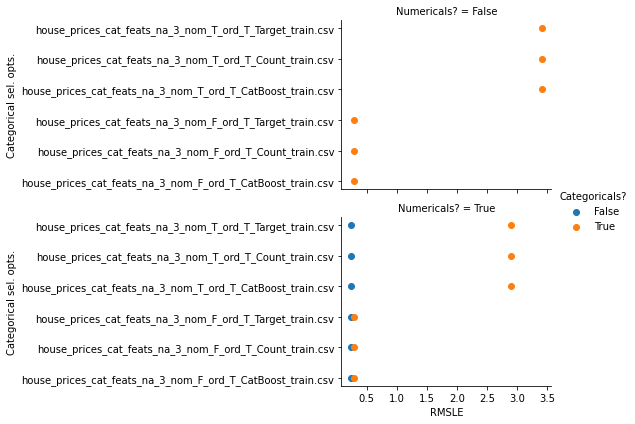

In [92]:
results_linR = run_test(cat_feats_files, num_feats_files)

As we see above, nominals are not helping the linear regression model. This, however, can be totally different with other models.

# Massive testing with different models


In [116]:
# List of dictionaries.
# Each contains a model name, it's estimator and a dict of hyperparameters
models_list = [
    {
        "name": "LogR",
        "estimator": LogisticRegression(),
        "hyperparameters":
            {
                "solver": ["newton-cg", "lbfgs", "liblinear"]
            }
    },
    {
        "name": "KNN Classifier",
        "estimator": KNeighborsClassifier(),
        "hyperparameters":
            {
                "n_neighbors": range(1,20,2),
                "weights": ["distance", "uniform"],
                "algorithm": ["ball_tree", "kd_tree", "brute"],
                "p": [1,2]
            }
    },
    {
        "name": "RF Classifier",
        "estimator": RandomForestClassifier(random_state=1),
        "hyperparameters":
            {
                "n_estimators": [4, 6, 9],
                "criterion": ["entropy", "gini"],
                "max_depth": [2, 5, 10],
                "max_features": ["log2", "sqrt"],
                "min_samples_leaf": [1, 5, 8],
                "min_samples_split": [2, 3, 5]

            }
    }
]

In [94]:
def test_models(df,target, models):
    
    features = df.drop(target, axis=1).columns
    
    all_X = df[features]
    all_y = df[target]

    for model in models:
        print('\n', 40*'-', '\n', model['name'], '\n', 40*'-')

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            scoring = 'neg_mean_squared_log_error', # Metric used in Kaggle
                            cv=10)

        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {:.2f}".format(model["best_score"]))
        print("Best Parameters: {}".format(model["best_params"]))

    return models

In [95]:
results = test_models(df, target='SalePrice', models=models_list)


 ---------------------------------------- 
 KNN Classifier 
 ----------------------------------------


C:\miniconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


Best Score: -0.06
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 1, 'p': 1, 'weights': 'distance'}


In [96]:
results

[{'name': 'LogR',
  'estimator': LogisticRegression(),
  'hyperparameters': {'solver': ['newton-cg', 'lbfgs', 'liblinear']}},
 {'name': 'KNN Classifier',
  'estimator': KNeighborsClassifier(),
  'hyperparameters': {'n_neighbors': range(1, 20, 2),
   'weights': ['distance', 'uniform'],
   'algorithm': ['ball_tree', 'kd_tree', 'brute'],
   'p': [1, 2]},
  'best_params': {'algorithm': 'brute',
   'n_neighbors': 1,
   'p': 1,
   'weights': 'distance'},
  'best_score': -0.0620164397739692,
  'best_model': KNeighborsClassifier(algorithm='brute', n_neighbors=1, p=1, weights='distance')},
 {'name': 'RF Classifier',
  'estimator': RandomForestClassifier(random_state=1),
  'hyperparameters': {'n_estimators': [4, 6, 9],
   'criterion': ['entropy', 'gini'],
   'max_depth': [2, 5, 10],
   'max_features': ['log2', 'sqrt'],
   'min_samples_leaf': [1, 5, 8],
   'min_samples_split': [2, 3, 5]}}]

In [99]:
def get_predictions(df, target, model):
    
    features = df.columns
    if target in features:
        features = df.drop(target, axis=1).columns

    print(df[features].shape)
    predictions = model.predict(df[features])
    
    return predictions

In [100]:
best_model = results[1]
best_model

{'name': 'KNN Classifier',
 'estimator': KNeighborsClassifier(),
 'hyperparameters': {'n_neighbors': range(1, 20, 2),
  'weights': ['distance', 'uniform'],
  'algorithm': ['ball_tree', 'kd_tree', 'brute'],
  'p': [1, 2]},
 'best_params': {'algorithm': 'brute',
  'n_neighbors': 1,
  'p': 1,
  'weights': 'distance'},
 'best_score': -0.0620164397739692,
 'best_model': KNeighborsClassifier(algorithm='brute', n_neighbors=1, p=1, weights='distance')}

In [101]:
df['predictions'] = get_predictions(df, 'SalePrice', best_model['best_model'])

(1460, 110)


In [102]:
df.head()

OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  TotalBsmtSF  \
Id                                                                              
1      0.666667   0.949275      0.883333     0.12250    0.125089     0.140098   
2      0.555556   0.753623      0.433333     0.00000    0.173281     0.206547   
3      0.666667   0.934783      0.866667     0.10125    0.086109     0.150573   
4      0.666667   0.311594      0.333333     0.00000    0.038271     0.123732   
5      0.777778   0.927536      0.833333     0.21875    0.116052     0.187398   

    1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  ...  nom_1Fam  nom_1.5Fin  \
Id                                               ...                         
1   0.119780   0.259231  0.666667      0.500000  ...  0.999001         0.0   
2   0.212942   0.174830  0.666667      0.333333  ...  0.999001         0.0   
3   0.134465   0.273549  0.666667      0.333333  ...  0.999001         0.0   
4   0.143873   0.260550  0.333333      0.416667  ...  0.999001         0.0   
5   0.186095   0.351168  0.666667      0.583333  ...  0.999001         0.0   

    nom_SFoyer  nom_RRAn  nom_Alloca  nom_Wall  nom_Pave  nom_2Story  \
Id                                                                     
1          0.0       0.0         0.0       0.0  0.999001    0.999001   
2          0.0       0.0         0.0       0.0  0.999001    0.000000   
3          0.0       0.0         0.0       0.0  0.999001    0.999001   
4          0.0       0.0         0.0       0.0  0.999001    0.999001   
5          0.0       0.0         0.0       0.0  0.999001    0.999001   

    nom_Family  predictions  
Id                           
1          0.0       208500  
2          0.0       181500  
3          0.0       223500  
4          0.0       140000  
5          0.0       250000  

[5 rows x 112 columns]

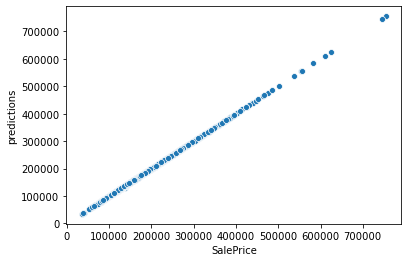

In [103]:
sns.scatterplot(data=df, x='SalePrice', y='predictions')

## Predict with test dataset

In [114]:
def train_and_predict(train, test, target, model):
    
    ml_model = model['best_model']
    ml_model.fit(train.drop(target, axis=1), train[target])
    predictions = ml_model.predict(test)

    return predictions

def train_and_predict_xgb(train, test, target, model):
    from xgboost import XGBRegressor
    
    xgb_model = XGBRegressor()
    xgb_model.fit(train.drop(target, axis=1), train[target])
    predictions = xgb_model.predict(test)

    return predictions

In [115]:
for idx, cat_file in enumerate(cat_feats_files):

    # Setup
    num_file = num_feats_files[0]
    num_file_test = num_feats_files_test[0]
    cat_file_test = cat_feats_files_test[idx]
    # Load train
    df_num = pd.read_csv("out/" + num_file, index_col='Id')
    df_cat = pd.read_csv("out/" + cat_file, index_col='Id')
    # Load test
    df_num_test = pd.read_csv("out/" + num_file_test, index_col='Id')
    df_cat_test = pd.read_csv("out/" + cat_file_test, index_col='Id')
    
    df = df_num.join(df_cat, how='inner')
    df_test = df_num_test.join(df_cat_test, how='inner')
    
    predictions = train_and_predict(df, df_test, 'SalePrice', best_model)
    
    submission = {
        "Id": df_test.index,
        "SalePrice": predictions
    }
    submission_df = pd.DataFrame(submission)
    submission_df.to_csv("out\delivery\predictions_" + cat_file_test, index=False)
    
    # Testing XGBoost Regresor
    predictions_xgb = train_and_predict_xgb(df, df_test, 'SalePrice', best_model)
    
    submission_xgb = {
        "Id": df_test.index,
        "SalePrice": predictions_xgb
    }
    submission_df_xgb = pd.DataFrame(submission_xgb)
    submission_df_xgb.to_csv("out\delivery\predictions_xgb_" + cat_file_test, index=False)

## Predictions with XGBoost Regresor


In [134]:
# Train
df_num = pd.read_csv('out\house_prices_num_feats_train.csv', index_col='Id')
df_cat = pd.read_csv('out\house_prices_cat_feats_na_3_nom_T_ord_T_Count_train.csv', index_col='Id')
df = df_num.join(df_cat, how='inner')
df.head()

OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  TotalBsmtSF  \
Id                                                                              
1      0.666667   0.949275      0.883333     0.12250    0.125089     0.140098   
2      0.555556   0.753623      0.433333     0.00000    0.173281     0.206547   
3      0.666667   0.934783      0.866667     0.10125    0.086109     0.150573   
4      0.666667   0.311594      0.333333     0.00000    0.038271     0.123732   
5      0.777778   0.927536      0.833333     0.21875    0.116052     0.187398   

    1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  ...  nom_FR3  nom_1Fam  \
Id                                               ...                      
1   0.119780   0.259231  0.666667      0.500000  ...      0.0  0.999001   
2   0.212942   0.174830  0.666667      0.333333  ...      0.0  0.999001   
3   0.134465   0.273549  0.666667      0.333333  ...      0.0  0.999001   
4   0.143873   0.260550  0.333333      0.416667  ...      0.0  0.999001   
5   0.186095   0.351168  0.666667      0.583333  ...      0.0  0.999001   

    nom_1.5Fin  nom_SFoyer  nom_RRAn  nom_Alloca  nom_Wall  nom_Pave  \
Id                                                                     
1          0.0         0.0       0.0         0.0       0.0  0.999001   
2          0.0         0.0       0.0         0.0       0.0  0.999001   
3          0.0         0.0       0.0         0.0       0.0  0.999001   
4          0.0         0.0       0.0         0.0       0.0  0.999001   
5          0.0         0.0       0.0         0.0       0.0  0.999001   

    nom_2Story  nom_Family  
Id                          
1     0.999001         0.0  
2     0.000000         0.0  
3     0.999001         0.0  
4     0.999001         0.0  
5     0.999001         0.0  

[5 rows x 111 columns]

In [135]:
# Test
df_num_t = pd.read_csv('out/house_prices_num_feats_test.csv', index_col='Id')
df_cat_t = pd.read_csv('out/house_prices_cat_feats_na_3_nom_T_ord_T_Count_test.csv', index_col='Id')
df_t = df_num_t.join(df_cat_t, how='inner')
df_t.head()

OverallQual  YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  \
Id                                                                   
1461            5       1961          1961         0.0       468.0   
1462            6       1958          1958       108.0       923.0   
1463            5       1997          1998         0.0       791.0   
1464            6       1998          1998        20.0       602.0   
1465            8       1992          1992         0.0       263.0   

      TotalBsmtSF  1stFlrSF  GrLivArea  FullBath  TotRmsAbvGrd  ...  nom_FR3  \
Id                                                              ...            
1461        882.0       896        896         1             5  ...      0.0   
1462       1329.0      1329       1329         1             6  ...      0.0   
1463        928.0       928       1629         2             6  ...      0.0   
1464        926.0       926       1604         2             7  ...      0.0   
1465       1280.0      1280       1280         2             5  ...      0.0   

      nom_1Fam  nom_1.5Fin  nom_SFoyer  nom_RRAn  nom_Alloca  nom_Wall  \
Id                                                                       
1461  0.999001         0.0         0.0       0.0         0.0       0.0   
1462  0.999001         0.0         0.0       0.0         0.0       0.0   
1463  0.999001         0.0         0.0       0.0         0.0       0.0   
1464  0.999001         0.0         0.0       0.0         0.0       0.0   
1465  0.000000         0.0         0.0       0.0         0.0       0.0   

      nom_Pave  nom_2Story  nom_Family  
Id                                      
1461  0.999001    0.000000         0.0  
1462  0.999001    0.000000         0.0  
1463  0.999001    0.999001         0.0  
1464  0.999001    0.999001         0.0  
1465  0.999001    0.000000         0.0  

[5 rows x 110 columns]

In [ ]:
from xgboost import XGBRFClassifier
from scipy.stats import uniform, randint
#from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split

X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

xgb_model = XGBRFClassifier()

params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3), # default 0.1 
    "max_depth": randint(2, 6), # default 3
    "n_estimators": randint(100, 150), # default 100
    "subsample": uniform(0.6, 0.4)
}

search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, n_iter=200, cv=10, verbose=1, n_jobs=1, return_train_score=True)

search.fit(X, y)

In [127]:
def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [130]:
report_best_scores(search.cv_results_, 8)

Model with rank: 1
Mean validation score: 0.884 (std: 0.048)
Parameters: {'colsample_bytree': 0.7039283369765, 'gamma': 0.3317686860083553, 'learning_rate': 0.08341079006092542, 'max_depth': 5, 'n_estimators': 140, 'subsample': 0.6594650911012452}

Model with rank: 2
Mean validation score: 0.880 (std: 0.040)
Parameters: {'colsample_bytree': 0.7135656010318567, 'gamma': 0.013183487248626002, 'learning_rate': 0.14293901006341486, 'max_depth': 2, 'n_estimators': 117, 'subsample': 0.9949104517259778}

Model with rank: 3
Mean validation score: 0.880 (std: 0.054)
Parameters: {'colsample_bytree': 0.7368330668988126, 'gamma': 0.4382220379376469, 'learning_rate': 0.22287766908427598, 'max_depth': 3, 'n_estimators': 101, 'subsample': 0.9642496014161216}

Model with rank: 4
Mean validation score: 0.880 (std: 0.052)
Parameters: {'colsample_bytree': 0.7412562832437979, 'gamma': 0.17053317552512925, 'learning_rate': 0.06404205637217672, 'max_depth': 4, 'n_estimators': 130, 'subsample': 0.95093574135

In [137]:
# Prediction with XGBoost Regresor

from xgboost import XGBClassifier

target = 'SalePrice'

xgb_model = XGBClassifier()

xgb_model.fit(df.drop(target, axis=1), df[target])
predictions_xgb = xgb_model.predict(df_test)
    
submission_xgb = {
    "Id": df_test.index,
    "SalePrice": predictions_xgb
}
submission_df_xgb = pd.DataFrame(submission_xgb)
submission_df_xgb.to_csv("out\delivery\predictions_xgb.csv", index=False)